In [1]:
## Create coordinates and vp, vs, density data to interpolate LWD between boreholes
## to add to Spatial Database

In [2]:
import pandas as pd
import numpy as np
import math
import sys
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import h5py

np.set_printoptions(threshold=sys.maxsize)

## Load in data - topography and LWD

In [3]:
## Load in topopgraphy points

topo = np.loadtxt("/Users/mckenziecarlson/Documents/GitHub/pylith_hikurangi/profile_2d/mesh/groundsurf-profile-coords2d.tsv")

p_U1518 = [-5541.6171, -2849.1, 0.0]
p_U1519 = [-34030.0862, -1264.0, 0.0]

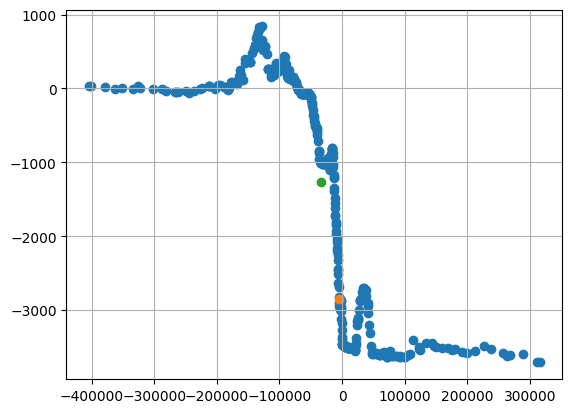

In [4]:
plt.scatter(topo[:,0],topo[:,1])
plt.scatter(p_U1518[0],p_U1518[1])
plt.scatter(p_U1519[0],p_U1519[1])
#plt.xlim([-34050,-34025])
plt.grid()

In [5]:
# plt.scatter(topo[:,0],topo[:,1])
# plt.scatter(p_U1518[0],p_U1518[1])
# plt.scatter(p_U1519[0],p_U1519[1])
# plt.xlim([-5600,-5000])
# plt.grid()

In [6]:
## Load in LWD Data and remove nans

# U1518 ----------
U1518_vel = pd.read_csv('/Users/mckenziecarlson/pylith/pylith-4.1.1-macOS-10.15-x86_64/aotearoa/U1518_vpvs.csv',skiprows=5)
U1518_vel.rename(columns={'m': 'depth(m)', 'km/s': 'vp(km/s)', 'km/s.1': 'vs(km/s)'}, inplace=True)
U1518_vel[U1518_vel==(-999.25)]=np.nan
U1518_vel = U1518_vel.sort_values('depth(m)')
#U1518_vel = U1518_vel.dropna(axis=0)
#U1518_vel.set_index('depth(m)',inplace=True)
# add to the depth column to reference to sealevel (same as spatial db)
#U1518_vel["depth(m)"] = (U1518_vel['depth(m)']+2630) * (-1)

U1518_den = pd.read_csv('/Users/mckenziecarlson/pylith/pylith-4.1.1-macOS-10.15-x86_64/aotearoa/U1518_density.csv',skiprows=5)
U1518_den.rename(columns={'m': 'depth(m)', 'g/cm3': 'density(g/cm3)'}, inplace=True)
U1518_den[U1518_den==(-999.25)]=np.nan
U1518_den = U1518_den.sort_values('depth(m)')
#U1518_den = U1518_den.dropna(axis=0)
#U1518_den.set_index('depth(m)',inplace=True)
# add to the depth column to reference to sealevel (same as spatial db)
#U1518_den["depth(m)"] = (U1518_den['depth(m)']+2630) * (-1)


#U1519 -----------
U1519_vel = pd.read_csv('/Users/mckenziecarlson/pylith/pylith-4.1.1-macOS-10.15-x86_64/aotearoa/U1519_vpvs.csv',skiprows=5)
U1519_vel.rename(columns={'m': 'depth(m)', 'km/s': 'vp(km/s)', 'km/s.1': 'vs(km/s)'}, inplace=True)
U1519_vel[U1519_vel==(-999.25)]=np.nan
U1519_vel = U1519_vel.sort_values('depth(m)')
#U1519_vel = U1519_vel.dropna(axis=0)
#U1519_vel.set_index('depth(m)',inplace=True)
# add to the depth column to reference to sealevel (same as spatial db)
#U1519_vel["depth(m)"] = (U1519_vel['depth(m)']+1000) * (-1)

U1519_den = pd.read_csv('/Users/mckenziecarlson/pylith/pylith-4.1.1-macOS-10.15-x86_64/aotearoa/U1519_density.csv',skiprows=5)
U1519_den.rename(columns={'m': 'depth(m)', 'g/cm3': 'density(g/cm3)'}, inplace=True)
U1519_den[U1519_den==(-999.25)]=np.nan
U1519_den = U1519_den.sort_values('depth(m)')
#U1519_den = U1519_den.dropna(axis=0)
#U1519_den.set_index('depth(m)',inplace=True)
# add to the depth column to reference to sealevel (same as spatial db)
#U1519_den["depth(m)"] = (U1519_den['depth(m)']+1000) * (-1)

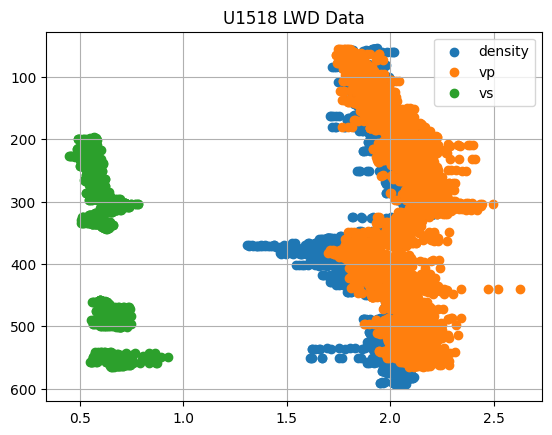

In [7]:
plt.scatter(U1518_den["density(g/cm3)"],U1518_den["depth(m)"],label='density')
plt.scatter(U1518_vel["vp(km/s)"],U1518_vel["depth(m)"],label='vp')
plt.scatter(U1518_vel["vs(km/s)"],U1518_vel["depth(m)"],label='vs')
plt.title('U1518 LWD Data')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

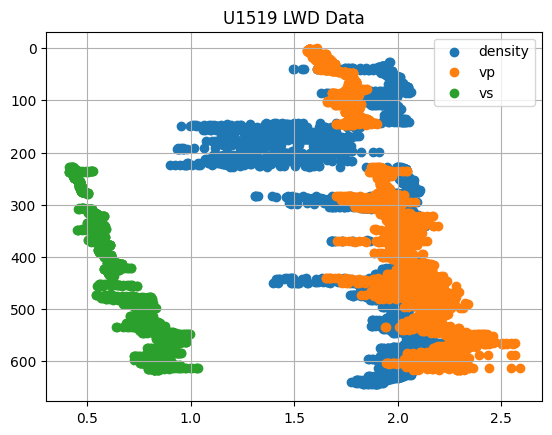

In [8]:
plt.scatter(U1519_den["density(g/cm3)"],U1519_den["depth(m)"],label='density')
plt.scatter(U1519_vel["vp(km/s)"],U1519_vel["depth(m)"],label='vp')
plt.scatter(U1519_vel["vs(km/s)"],U1519_vel["depth(m)"],label='vs')
plt.title('U1519 LWD Data')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

## Generate fits to data - first with polynomial then with linear piecewise

In [9]:
## Define function for fitting piecewise data. It returns inflection points of piecewise function, can fit a line in between
## taken from https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a

def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

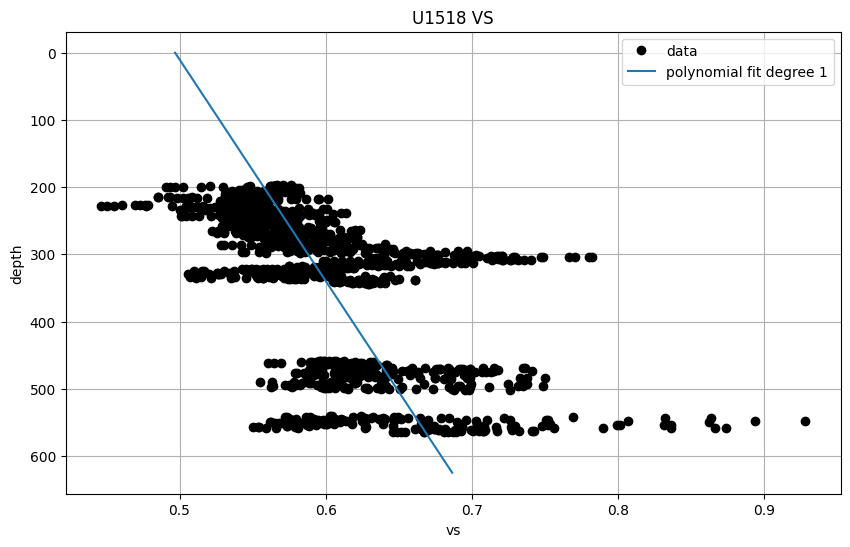

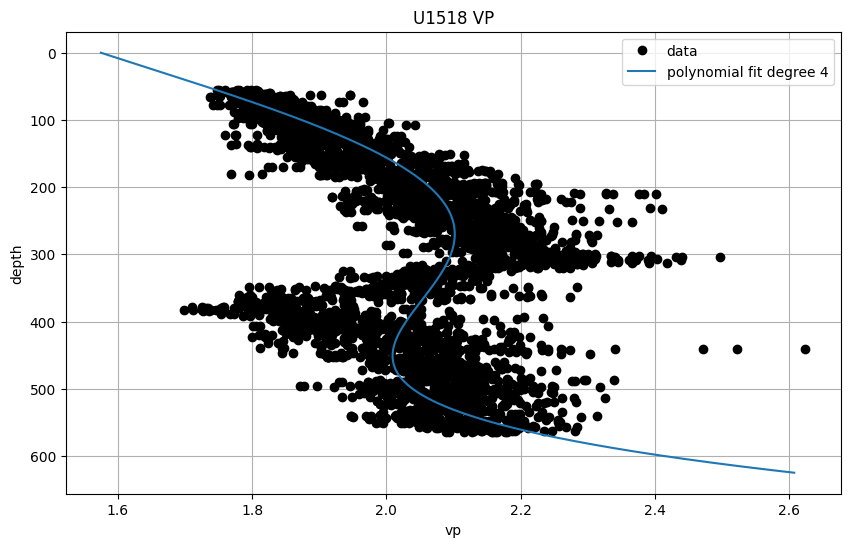

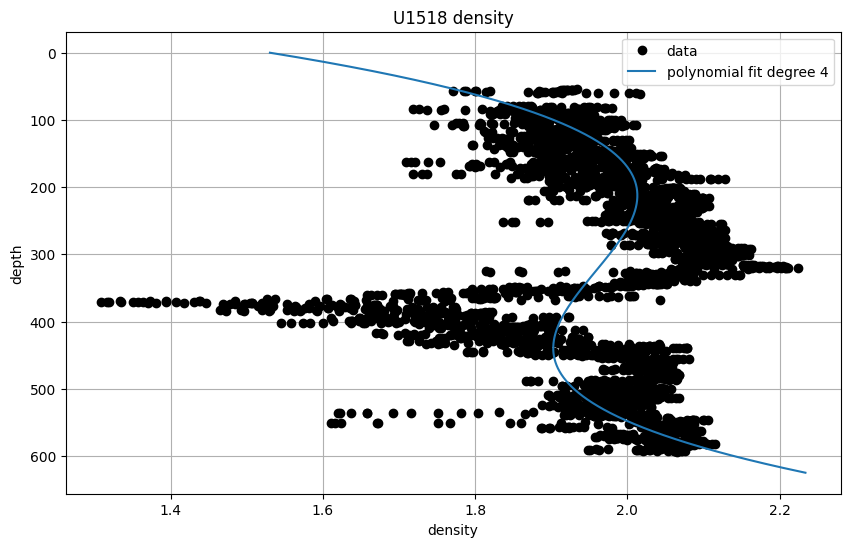

In [10]:
## Fit line to data using polynomial fits - U1518

## U1518 vs -----------------
idx = np.isfinite(U1518_vel["depth(m)"]) & np.isfinite(U1518_vel["vs(km/s)"])

x = U1518_vel["depth(m)"][idx]
y = U1518_vel["vs(km/s)"][idx]


c1 = np.polyfit(x, y, 1) # Calculate the polynomial fit (linear)
D1 = np.arange(0, 625, 0.2) # generate some grain diameter values
w1 = np.polyval(c1, D1)

# generate points in polynomial function
U1518_vs = w1
U1518_vs_depth = D1

# Plot fit to data
plt.figure(figsize = (10, 6))
plt.plot(y, x, 'ko', label='data')
plt.plot(w1, D1, label='polynomial fit degree 1')
plt.legend(loc = 'best')
plt.xlabel('vs')
plt.ylabel('depth')
plt.title('U1518 VS')
plt.gca().invert_yaxis()
plt.grid()

## U1518 vp ----------------

idx = np.isfinite(U1518_vel["depth(m)"]) & np.isfinite(U1518_vel["vp(km/s)"])

x = U1518_vel["depth(m)"][idx]
y = U1518_vel["vp(km/s)"][idx]


c1 = np.polyfit(x, y, 4) # Calculate the polynomial fit
D1 = np.arange(0, 625, 0.2) # generate some grain diameter values
w1 = np.polyval(c1, D1)

# Plot fit to data
plt.figure(figsize = (10, 6))
plt.plot(y, x, 'ko', label='data')
plt.plot(w1, D1, label='polynomial fit degree 4')
plt.legend(loc = 'best')
plt.xlabel('vp')
plt.ylabel('depth')
plt.title('U1518 VP')
plt.gca().invert_yaxis()
plt.grid()

## U1518 density --------------

idx = np.isfinite(U1518_den["density(g/cm3)"]) & np.isfinite(U1518_den["density(g/cm3)"])

x = U1518_den["depth(m)"][idx]
y = U1518_den["density(g/cm3)"][idx]


c1 = np.polyfit(x, y, 4) # Calculate the polynomial fit
D1 = np.arange(0, 625, 0.2) # generate some grain diameter values
w1 = np.polyval(c1, D1)

# Plot fit to data
plt.figure(figsize = (10, 6))
plt.plot(y, x, 'ko', label='data')
plt.plot(w1, D1, label='polynomial fit degree 4')
plt.legend(loc = 'best')
plt.xlabel('density')
plt.ylabel('depth')
plt.title('U1518 density')
plt.gca().invert_yaxis()
plt.grid()

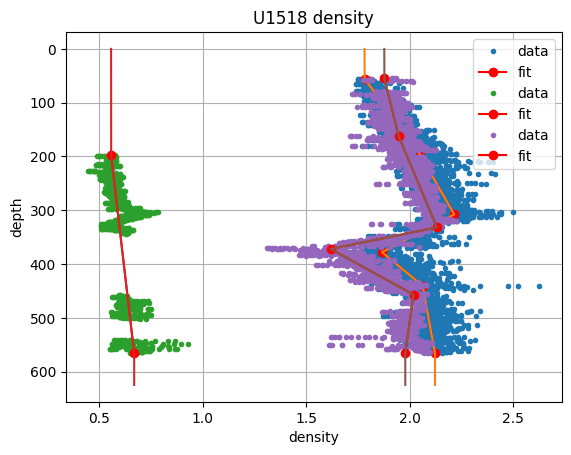

In [11]:
## Fit piecewise linear functions to data - U1518

## U1518 vp -------------------

idx = np.isfinite(U1518_vel["depth(m)"]) & np.isfinite(U1518_vel["vp(km/s)"])
x = U1518_vel["depth(m)"][idx]
y = U1518_vel["vp(km/s)"][idx]

# fit piecewise
px, py = segments_fit(x, y, 5)

plt.plot(y, x, ".",label='data')
plt.plot(py, px, "-or",label='fit')
plt.legend(loc = 'best')
plt.xlabel('vp')
plt.ylabel('depth')
plt.title('U1518 vp')
plt.gca().invert_yaxis()
plt.grid()

x_range = np.arange(0, 625, 0.2)
y_range = np.interp(x_range, px, py)
plt.plot(y_range,x_range)

# generate points in piecewise function
U1518_vp = y_range
U1518_vp_depth = x_range


## U1518 vs -----------------

idx = np.isfinite(U1518_vel["depth(m)"]) & np.isfinite(U1518_vel["vs(km/s)"])
x = U1518_vel["depth(m)"][idx]
y = U1518_vel["vs(km/s)"][idx]

px, py = segments_fit(x, y, 1)

plt.plot(y, x, ".",label='data')
plt.plot(py, px, "-or",label='fit')
plt.legend(loc = 'best')
plt.xlabel('vs')
plt.ylabel('depth')
plt.title('U1518 vs')
plt.gca().invert_yaxis()
plt.grid()

x_range = np.arange(0, 625, 0.2)
y_range = np.interp(x_range, px, py)
plt.plot(y_range,x_range)


## U1518 density -----------------

idx = np.isfinite(U1518_vel["depth(m)"]) & np.isfinite(U1518_den["density(g/cm3)"])
x = U1518_den["depth(m)"][idx]
y = U1518_den["density(g/cm3)"][idx]

px, py = segments_fit(x, y, 5)

plt.plot(y, x, ".",label='data')
plt.plot(py, px, "-or",label='fit')
plt.legend(loc = 'best')
plt.xlabel('density')
plt.ylabel('depth')
plt.title('U1518 density')
plt.gca().invert_yaxis()
plt.grid()

x_range = np.arange(0, 625, 0.2)
y_range = np.interp(x_range, px, py)

plt.plot(y_range,x_range)

# generate points in piecewise function
U1518_density = y_range
U1518_density_depth = x_range

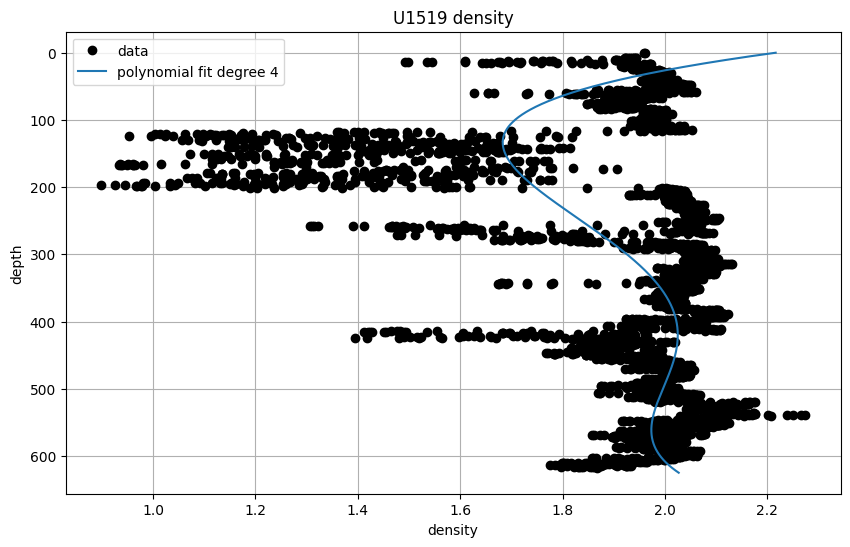

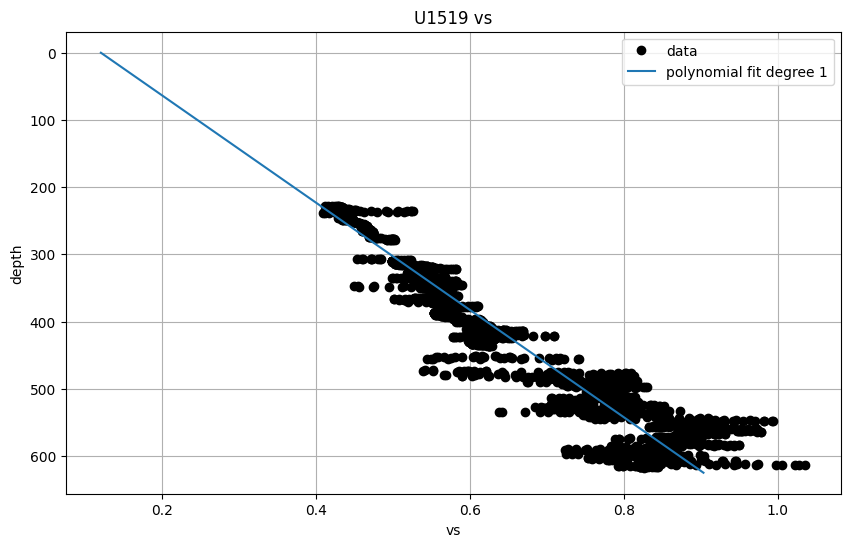

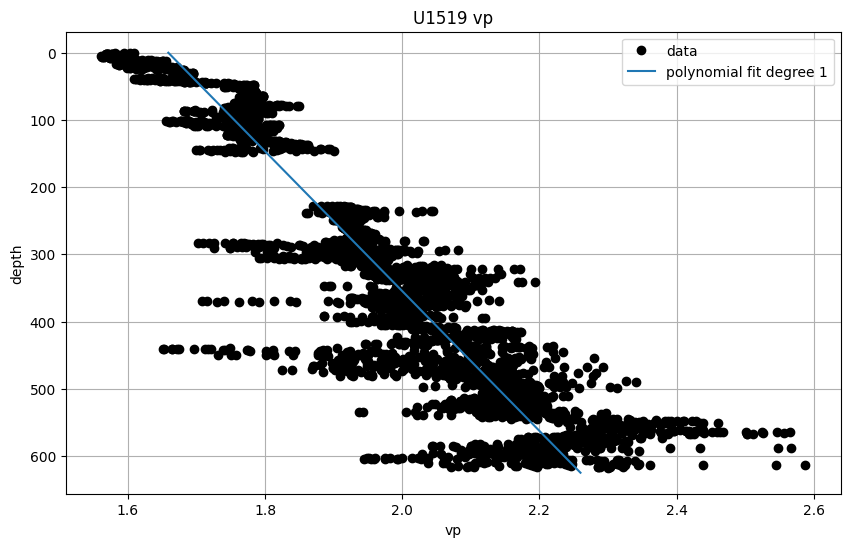

In [12]:
## Fit line to data using polynomial fits - U1519


## U1519 density ------------
idx = np.isfinite(U1519_vel["depth(m)"]) & np.isfinite(U1519_den["density(g/cm3)"])

x = U1519_vel["depth(m)"][idx]
y = U1519_den["density(g/cm3)"][idx]


c1 = np.polyfit(x, y, 4) # Calculate the polynomial fit (linear)
D1 = np.arange(0, 625, 0.2) # generate some grain diameter values
w1 = np.polyval(c1, D1)

# Plot fit to data
plt.figure(figsize = (10, 6))
plt.plot(y, x, 'ko', label='data')
plt.plot(w1, D1, label='polynomial fit degree 4')
plt.legend(loc = 'best')
plt.xlabel('density')
plt.ylabel('depth')
plt.title('U1519 density')
plt.gca().invert_yaxis()
plt.grid()

## U1519 vs -----------------

idx = np.isfinite(U1519_vel["depth(m)"]) & np.isfinite(U1519_vel["vs(km/s)"])

x = U1519_vel["depth(m)"][idx]
y = U1519_vel["vs(km/s)"][idx]


c1 = np.polyfit(x, y, 1) # Calculate the polynomial fit (linear)
D1 = np.arange(0, 625, 0.2) # generate some grain diameter values
w1 = np.polyval(c1, D1)

# generate points in polynomial function
U1519_vs = w1
U1519_vs_depth = D1

# Plot fit to data
plt.figure(figsize = (10, 6))
plt.plot(y, x, 'ko', label='data')
plt.plot(w1, D1, label='polynomial fit degree 1')
plt.legend(loc = 'best')
plt.xlabel('vs')
plt.ylabel('depth')
plt.title('U1519 vs')
plt.gca().invert_yaxis()
plt.grid()

## U1519 vp -----------------

idx = np.isfinite(U1519_vel["depth(m)"]) & np.isfinite(U1519_vel["vp(km/s)"])

x = U1519_vel["depth(m)"][idx]
y = U1519_vel["vp(km/s)"][idx]


c1 = np.polyfit(x, y, 1) # Calculate the polynomial fit (linear)
D1 = np.arange(0, 625, 0.2) # generate some grain diameter values
w1 = np.polyval(c1, D1)

# generate points in polynomial function
U1519_vp = w1
U1519_vp_depth = D1

# Plot fit to data
plt.figure(figsize = (10, 6))
plt.plot(y, x, 'ko', label='data')
plt.plot(w1, D1, label='polynomial fit degree 1')
plt.legend(loc = 'best')
plt.xlabel('vp')
plt.ylabel('depth')
plt.title('U1519 vp')
plt.gca().invert_yaxis()
plt.grid()

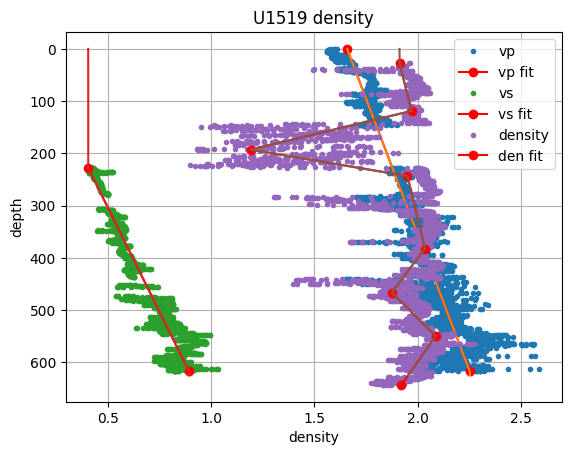

In [13]:
## Fit piecewise linear functions to data - U1519

## U1519 vp -------------------

idx = np.isfinite(U1519_vel["depth(m)"]) & np.isfinite(U1519_vel["vp(km/s)"])
x = U1519_vel["depth(m)"][idx]
y = U1519_vel["vp(km/s)"][idx]

px, py = segments_fit(x, y, 1)

plt.plot(y, x, ".",label='vp')
plt.plot(py, px, "-or",label='vp fit')
plt.legend(loc = 'best')
plt.xlabel('vp')
plt.ylabel('depth')
plt.title('U1519 vp')
plt.gca().invert_yaxis()
plt.grid()

x_range = np.arange(0, 625, 0.2)
y_range = np.interp(x_range, px, py)
plt.plot(y_range,x_range)

## U1519 vs -----------------

idx = np.isfinite(U1519_vel["depth(m)"]) & np.isfinite(U1519_vel["vs(km/s)"])
x = U1519_vel["depth(m)"][idx]
y = U1519_vel["vs(km/s)"][idx]

px, py = segments_fit(x, y, 1)

plt.plot(y, x, ".",label='vs')
plt.plot(py, px, "-or",label='vs fit')
plt.legend(loc = 'best')
plt.xlabel('vs')
plt.ylabel('depth')
plt.title('U1519 vs')
plt.gca().invert_yaxis()
plt.grid()

x_range = np.arange(0, 625, 0.2)
y_range = np.interp(x_range, px, py)
plt.plot(y_range,x_range)

## U1519 density -----------------

idx = np.isfinite(U1519_vel["depth(m)"]) & np.isfinite(U1519_den["density(g/cm3)"])
x = U1519_den["depth(m)"][idx]
y = U1519_den["density(g/cm3)"][idx]

px, py = segments_fit(x, y, 7)

plt.plot(y, x, ".",label='density')
plt.plot(py, px, "-or",label='den fit')
plt.legend(loc = 'best')
plt.xlabel('density')
plt.ylabel('depth')
plt.title('U1519 density')
plt.gca().invert_yaxis()
plt.grid()

# generate points in piecewise function
x_range = np.arange(0, 625, 0.2)
y_range = np.interp(x_range, px, py)
plt.plot(y_range,x_range)

U1519_density = y_range
U1519_density_depth = x_range

### Make dataframes for final data

In [14]:
## Generate data for U1518
## Use linear polynomal for vs, piecewise linear for vp and density

d = {'depth': U1518_vs_depth, 'vs': U1518_vs, 'vp': U1518_vp, 'density': U1518_density}

U1518_data_df = pd.DataFrame(data=d)
U1518_data_df

,depth,vs,vp,density
0,0.0,0.496940,1.781069,1.876504
1,0.2,0.497001,1.781069,1.876504
2,0.4,0.497061,1.781069,1.876504
3,0.6,0.497122,1.781069,1.876504
4,0.8,0.497183,1.781069,1.876504
...,...,...,...,...
3120,624.0,0.686212,2.121321,1.977911
3121,624.2,0.686273,2.121321,1.977911
3122,624.4,0.686333,2.121321,1.977911
3123,624.6,0.686394,2.121321,1.977911


In [ ]:
## Generate data for U1519
## Use linear polynomal for vs and vp, piecewise linear for density

d = {'depth': U1519_vs_depth, 'vs': U1519_vs, 'vp': U1519_vp, 'density': U1519_density}

U1519_data_df = pd.DataFrame(data=d)
U1519_data_df

,depth,vs,vp,density
0,0.0,0.120449,1.658870,1.912369
1,0.2,0.120699,1.659062,1.912369
2,0.4,0.120950,1.659255,1.912369
3,0.6,0.121201,1.659447,1.912369
4,0.8,0.121451,1.659640,1.912369
...,...,...,...,...
3120,624.0,0.902493,2.259102,1.955716
3121,624.2,0.902744,2.259294,1.955361
3122,624.4,0.902995,2.259486,1.955006
3123,624.6,0.903245,2.259679,1.954652


## Old method for generating data - interpolating between points.

In [16]:
## Set depth to index column

# U1518_vel.set_index('depth(m)',inplace=True)
# U1518_den.set_index('depth(m)',inplace=True)
# U1519_vel.set_index('depth(m)',inplace=True)
# U1519_den.set_index('depth(m)',inplace=True)

In [17]:
# narrow18_vel = U1518_vel.loc[227.6:565]
# narrow18_den = U1518_den.loc[227.6:565]
# narrow19_vel = U1519_vel.loc[227.6:565]
# narrow19_den = U1519_den.loc[227.6:565]

# depth_resampled = np.linspace(227.6,565.0,300)

# U1518_vel_resampled = narrow18_vel.reindex(narrow18_vel.index.union(depth_resampled)).interpolate('values').loc[depth_resampled].reset_index()
# U1518_vel_resampled = U1518_vel_resampled.dropna(axis=0)
# U1518_den_resampled = narrow18_den.reindex(narrow18_den.index.union(depth_resampled)).interpolate('values').loc[depth_resampled].reset_index()
# U1518_den_resampled = U1518_den_resampled.dropna(axis=0)
# U1519_vel_resampled = narrow19_vel.reindex(narrow19_vel.index.union(depth_resampled)).interpolate('values').loc[depth_resampled].reset_index()
# U1519_vel_resampled = U1519_vel_resampled.dropna(axis=0)
# U1519_den_resampled = narrow19_den.reindex(narrow19_den.index.union(depth_resampled)).interpolate('values').loc[depth_resampled].reset_index()
# U1519_den_resampled = U1519_den_resampled.dropna(axis=0)

# narrow18_vel = narrow18_vel.reset_index()
# narrow18_den = narrow18_den.reset_index()
# narrow19_vel = narrow19_vel.reset_index()
# narrow19_den = narrow19_den.reset_index()

In [18]:
# depth_resampled

In [19]:
# plt.plot(narrow18_vel['vp(km/s)'],narrow18_vel['depth(m)'],label='lwd data')
# plt.plot(U1518_vel_resampled['vp(km/s)'],U1518_vel_resampled['depth(m)'],color='red',label='lwd resampled')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.ylabel('depth (mbsf)')
# plt.xlabel('vp (km/s)')
# plt.title('U1518 VP')
# plt.legend()

In [20]:
# plt.plot(narrow18_vel['vs(km/s)'],narrow18_vel['depth(m)'],label='lwd data')
# plt.plot(U1518_vel_resampled['vs(km/s)'],U1518_vel_resampled['depth(m)'],color='red',label='lwd resampled')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.ylabel('depth (mbsf)')
# plt.xlabel('vs (km/s)')
# plt.title('U1518 VS')
# plt.legend()

In [21]:
# plt.plot(narrow18_den['density(g/cm3)'],narrow18_den['depth(m)'],label='lwd data')
# plt.plot(U1518_den_resampled['density(g/cm3)'],U1518_den_resampled['depth(m)'],color='red',label='lwd resampled')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.ylabel('depth (mbsf)')
# plt.xlabel('density (g/cm3)')
# plt.title('U1518 density')
# plt.legend()

In [22]:
# plt.plot(narrow19_vel['vp(km/s)'],narrow19_vel['depth(m)'],label='lwd data')
# plt.plot(U1519_vel_resampled['vp(km/s)'],U1519_vel_resampled['depth(m)'],color='red',label='lwd resampled')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.ylabel('depth (mbsf)')
# plt.xlabel('vp (km/s)')
# plt.title('U1519 VP')
# plt.legend()

In [23]:
# plt.plot(narrow19_vel['vs(km/s)'],narrow19_vel['depth(m)'],label='lwd data')
# plt.plot(U1519_vel_resampled['vs(km/s)'],U1519_vel_resampled['depth(m)'],color='red',label='lwd resampled')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.ylabel('depth (mbsf)')
# plt.xlabel('vs (km/s)')
# plt.title('U1519 VS')
# plt.legend()

In [24]:
# plt.plot(narrow19_den['density(g/cm3)'],narrow19_den['depth(m)'],label='lwd data')
# plt.plot(U1519_den_resampled['density(g/cm3)'],U1519_den_resampled['depth(m)'],color='red',label='lwd resampled')
# plt.grid()
# plt.gca().invert_yaxis()
# plt.ylabel('depth (mbsf)')
# plt.xlabel('density (g/cm3)')
# plt.title('U1519 density')
# plt.legend()

## Generate (x,y) coordinates for data points using topopgraphy and depth

In [25]:
# Find index nearest boreholes and extend by 5 data points
end_idx = np.where(topo == -2.68720920e+03)[0][0] + 5
start_idx = np.where(topo == -1.00629570e+03)[0][0] - 5

x_range = np.linspace(topo[start_idx,0], topo[end_idx,0], 200)

# Interpolate y values so that vector is the same length as x values
y_vals_for_x_range = topo[start_idx:end_idx+1,:]
interpolator = interp1d(y_vals_for_x_range[:,0], y_vals_for_x_range[:,1], kind='linear')  # Linear interpolation

topo_range = interpolator(x_range)

print(len(x_range))
x_range

200


array([-37085.41863064, -36918.37838445, -36751.33813825, -36584.29789205,
       -36417.25764585, -36250.21739965, -36083.17715345, -35916.13690725,
       -35749.09666105, -35582.05641485, -35415.01616865, -35247.97592245,
       -35080.93567625, -34913.89543005, -34746.85518385, -34579.81493766,
       -34412.77469146, -34245.73444526, -34078.69419906, -33911.65395286,
       -33744.61370666, -33577.57346046, -33410.53321426, -33243.49296806,
       -33076.45272186, -32909.41247566, -32742.37222946, -32575.33198326,
       -32408.29173707, -32241.25149087, -32074.21124467, -31907.17099847,
       -31740.13075227, -31573.09050607, -31406.05025987, -31239.01001367,
       -31071.96976747, -30904.92952127, -30737.88927507, -30570.84902887,
       -30403.80878267, -30236.76853647, -30069.72829028, -29902.68804408,
       -29735.64779788, -29568.60755168, -29401.56730548, -29234.52705928,
       -29067.48681308, -28900.44656688, -28733.40632068, -28566.36607448,
       -28399.32582828, -

In [32]:
## Generate dataframe with vs, vp, and density at each point

d = []
for i in range(0,len(U1518_data_df)):
    for j in range(0,len(x_range)-1):
        x = x_range[j]
        depth = U1518_data_df['depth'][i]
        y = topo_range[j] - depth

        # Linearly interpolate vs, vp, and density between two boreholes
        vs_range = np.linspace(U1519_data_df['vs'][i],U1518_data_df['vs'][i],len(x_range))
        vs = vs_range[j] * 1000

        vp_range = np.linspace(U1519_data_df['vp'][i],U1518_data_df['vp'][i],len(x_range))
        vp = vp_range[j] * 1000

        den_range = np.linspace(U1519_data_df['density'][i],U1518_data_df['density'][i],len(x_range))
        den = den_range[j] * 1000

        d.append(
            {
                'x_coord': x,
                'depth_coord': y,
                'vs': vs,
                'vp': vp,
                'density': den
            }
        )

data = pd.DataFrame(d)

In [34]:
data

,x_coord,depth_coord,vs,vp,density
0,-37085.418631,-873.100770,120.448752,1658.870011,1912.368552
1,-36918.378384,-886.492350,122.340668,1659.484074,1912.188331
2,-36751.338138,-899.883930,124.232584,1660.098137,1912.008109
3,-36584.297892,-913.275510,126.124500,1660.712200,1911.827888
4,-36417.257646,-926.667091,128.016416,1661.326264,1911.647666
...,...,...,...,...,...
621870,-4679.610868,-3539.921075,691.907967,2124.802218,1977.317658
621871,-4512.570622,-3570.529334,690.817307,2124.105987,1977.436320
621872,-4345.530376,-3583.974252,689.726648,2123.409755,1977.554981
621873,-4178.490129,-3594.239573,688.635988,2122.713523,1977.673643


In [35]:
#data.to_csv('lwd_sdb_points_full.csv', index=False)  

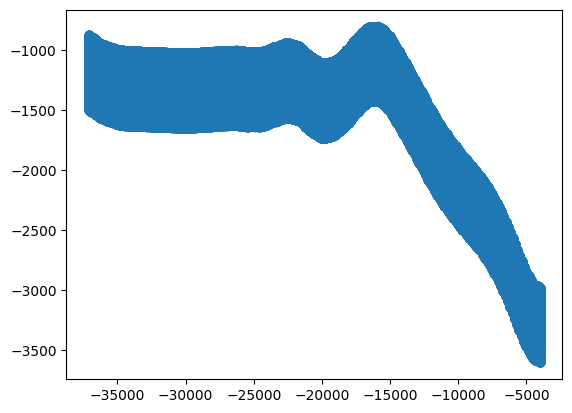

In [36]:
plt.scatter(data['x_coord'],data['depth_coord'])

In [37]:
## Subsample data at every 10m depth

# Parameters
sample_size = 199
skip_size = sample_size * 50

# Create an empty list to hold the sampled data
sampled_data = []

# Iterate over the DataFrame in chunks
for start in range(0, len(data), sample_size + skip_size):
    end = start + sample_size
    sampled_data.append(data.iloc[start:end])

# Concatenate all the sampled chunks into a single DataFrame
sampled_df = pd.concat(sampled_data, ignore_index=True)

# Print the shape of the sampled DataFrame to verify
print(sampled_df.shape)
sampled_df

(12338, 5)


,x_coord,depth_coord,vs,vp,density
0,-37085.418631,-873.100770,120.448752,1658.870011,1912.368552
1,-36918.378384,-886.492350,122.340668,1659.484074,1912.188331
2,-36751.338138,-899.883930,124.232584,1660.098137,1912.008109
3,-36584.297892,-913.275510,126.124500,1660.712200,1911.827888
4,-36417.257646,-926.667091,128.016416,1661.326264,1911.647666
...,...,...,...,...,...
12333,-4679.610868,-3537.321075,691.057276,2124.739380,1977.433481
12334,-4512.570622,-3567.929334,689.979028,2124.055716,1977.528978
12335,-4345.530376,-3581.374252,688.900780,2123.372052,1977.624475
12336,-4178.490129,-3591.639573,687.822532,2122.688388,1977.719972


In [39]:
sampled_df.to_csv('downsampled_lwd_new.csv', index=False) 